# Clustering Preparaton
- Last Edit: 01/17/2020
- note: two step clustering so that New England is not too big of a market 

## Overview



input: 
- coordinates : dec13_total_df.csv 
- parameters for OPTICS 

Outputs: 
- labeled coordinates :   es_labeled'+parameters+'.csv'
- coordinates graph for illustration



In [1]:
from sklearn.cluster import OPTICS
from sklearn.cluster import DBSCAN
import csv 
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from sklearn.cluster import OPTICS
from sklearn.neighbors import DistanceMetric
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

import geopandas as gpd

from shapely.geometry import Point, Polygon, MultiPoint
import matplotlib.pyplot as plt

### Version 
Use string version and use this in output file name string

In [2]:
version='dec_06'

### Import data for clustering 

In [4]:
pwd

'C:\\Users\\Herbie Huang\\Google Drive\\Current_SolarResearch\\working_june2020\\solar_project\\1_code'

In [6]:
import os 
import pandas as pd
total_df_url='../0_data/dec14_total_df.csv' 
total_df=pd.read_csv(total_df_url)
#total_coords=get_coords(total_df)

### Helper functions

#### helper function get_coords - two versions: dropdup vs not dropdup 

In [10]:
def get_coords( dataframe ):
    #df=dataframe[['installerid','lat','long']]
    df=dataframe[['lat','long']]
    df=df.dropna().drop_duplicates()
    coords=df.as_matrix(columns=['lat','long'])
    return coords;



#### Helper Function: Get Centroid

In [11]:
def get_centroid(cluster):
    centroid = (MultiPoint(cluster).centroid.y, MultiPoint(cluster).centroid.x)
    return tuple(centroid)

#### Helper Function: Haversine distance

In [12]:
from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):

      R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

      dLat = radians(lat2 - lat1)
      dLon = radians(lon2 - lon1)
      lat1 = radians(lat1)
      lat2 = radians(lat2)

      a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
      c = 2*asin(sqrt(a))

      return R * c

##  Define the OPTICS routine
Notice: min_sample is the humber of samples ina neighborfhood for a point to be considered as a core point. This is to be
 
### important parameters for OPTICS
#### Parameters:  	
* __min_samples__ : int (default=5)
The number of samples in a neighborhood for a point to be considered as a core point.

* __max_eps__ : float, optional (default=np.inf)
The maximum distance between two samples for them to be considered as in the same neighborhood. Default value of “np.inf” will identify clusters across all scales; reducing max_eps will result in shorter run times.  
* __eps__: float, optional (default=0.5)
The maximum distance between two samples for them to be considered as in the same neighborhood. Used ony when cluster_method='dbscan  

#### Outputs:
* include the silhouette score and calinski-harabasz score
* and the cluster object op and parameters 
#### Data Inputs:  
__coords__: coordinates 

In [13]:
def optics_coords_v2(radius,max_ep,min_size,coords):
    kms_per_radian = 6371.0088
    epsilon = radius / kms_per_radian
    print('ready to cluster with radius= '+str(radius)+'max_ep: '+str(max_ep)+' and min_size: '+str(min_size))
    op=OPTICS(min_samples=min_size, max_eps=max_ep, metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1], p=2,
                 metric_params=None, cluster_method='dbscan', eps=epsilon, algorithm='ball_tree', leaf_size=30,
                 n_jobs=None).fit(np.radians(coords))
    #print('we are done clustering...just computing the sil score')
    sil_score=metrics.silhouette_score(coords, op.labels_,metric=lambda X,Y: DistanceMetric.get_metric('haversine').pairwise([X,Y])[0][1])        
    #print('the sil score is '+str(sil_score))
    labels = op.labels_
    X =coords
    cal_score=metrics.calinski_harabasz_score(X, labels) 
    cluster_num=len(set(labels))
    return [op,radius,min_size,sil_score,cal_score,cluster_num]

### Helper function: Plot only function

In [14]:
def plot_coordinates_us(coords):
    mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)
    
    coords_df=pd.DataFrame()
    coords_df['Coordinates']=tuple(zip(coords['long'],coords['lat']))
    coords_df['Coordinates']=coords_df
    coords_df['Coordinates']=coords_df['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    gdf=gpd.GeoDataFrame(coords_df,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
    
    plt.savefig('testplot')
    plt.show()
    

### Helper function: Cluster and Plot function

In [15]:
def cluster_and_plot(radius, max_eps,min_size,coords):
# run the optics 
    optics_run=optics_coords_v2(radius,max_eps,min_size,coords)
# collect cluster results  
    temp_reduced_optics_output=pd.DataFrame(columns=['labels','lat','long'])
    temp_reduced_optics_output['labels']=optics_run[0].labels_
    temp_reduced_optics_output['lat']=coords[:,0]
    temp_reduced_optics_output['long']=coords[:,1]
#find centroid for plotting 
    total_cluster_ct=[]
    for label in set(temp_reduced_optics_output.labels):
        #print(label)
        temp_centroid=get_centroid(get_coords(temp_reduced_optics_output[temp_reduced_optics_output['labels']==label]))
        total_cluster_ct=total_cluster_ct+[temp_centroid]

    cluster_centroids=pd.DataFrame()
    cluster_centroids['Coordinates']=total_cluster_ct
    cluster_centroids['Coordinates']=cluster_centroids['Coordinates'].apply(Point)
# put into a geopandas dataframe 
    mapurl='C:/Users/herbie huang/Google Drive/Current_SolarResearch/rawdata_geospatial/states_21basic/states.shp'
    usa=gpd.read_file(mapurl)

    gdf=gpd.GeoDataFrame(cluster_centroids,geometry='Coordinates')
    ax=usa[(usa.STATE_NAME!='Alaska')&(usa.STATE_NAME!='Hawaii')].plot(color='white',edgecolor='black',markersize=0.2,figsize=(20,10))
    # We can now plot our GeoDataFrame.

    gdf.plot(ax=ax, color='blue')
   
    plt.savefig('testplot.jpg')
    plt.show()
    # output : the labeled original coords 
    #temp_output=pd.DataFrame(columns=['labels','lat','long'])
    #temp_output['labels']=optics_run_total[0].labels_
    #temp_output['lat']=total_df_reduced[:,0]
    #temp_output['long']=total_df_reduced[:,1]
 # return the original results 
    return optics_run

## Data Exploration

### Plot the ES installers alone

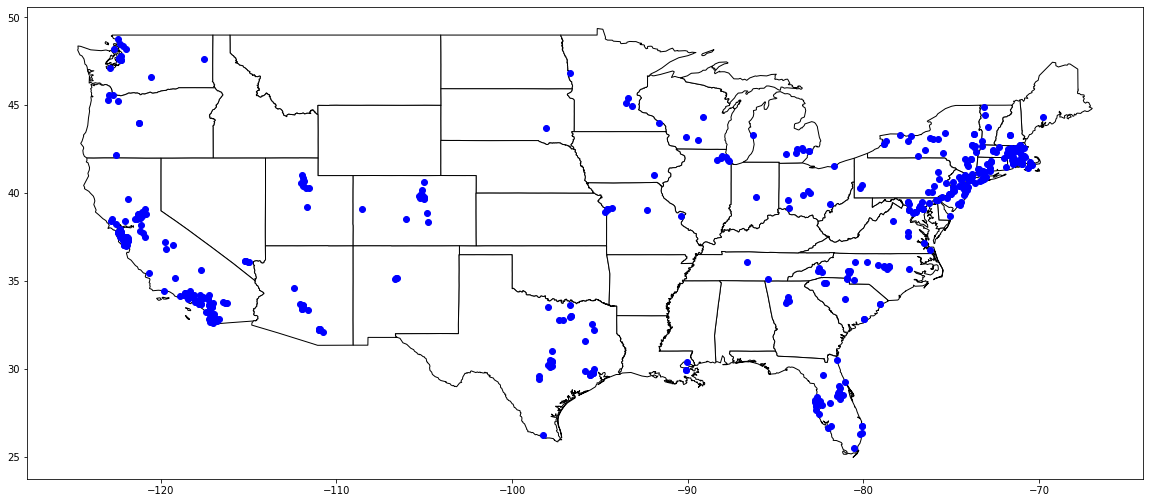

In [16]:
plot_coordinates_us(total_df[total_df['isES']==1])

### Example: a cluster routine 

get coordinates for clustering

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 90max_ep: 100 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


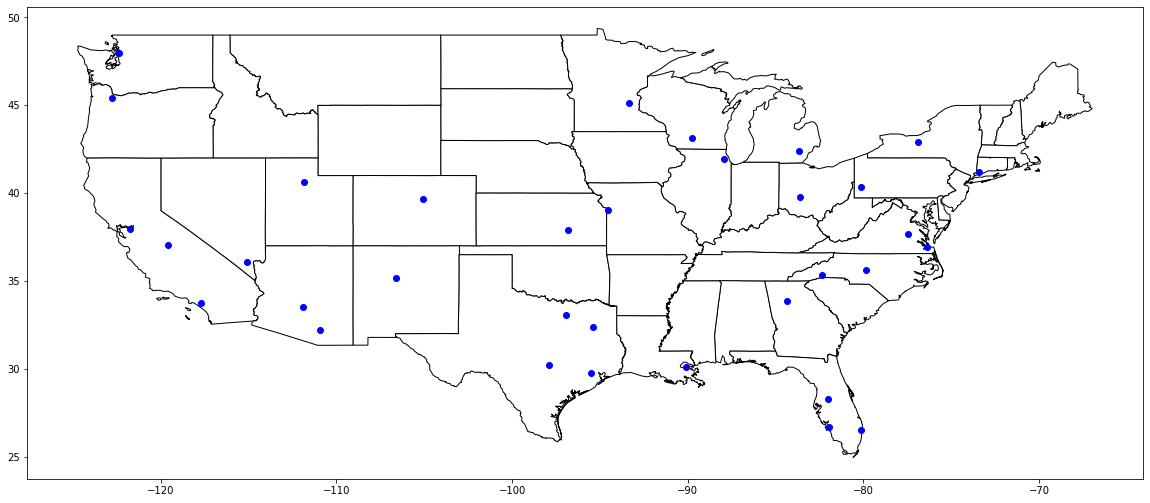

In [17]:
es_coords=get_coords(total_df[total_df['isES']==1])

cluster_es=cluster_and_plot(90,100,2,es_coords)

Run the cluster and plot function

# Clustering Step: radius=90, min_size=2 

## Clustering First Step

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 90max_ep: 100 and min_size: 2


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


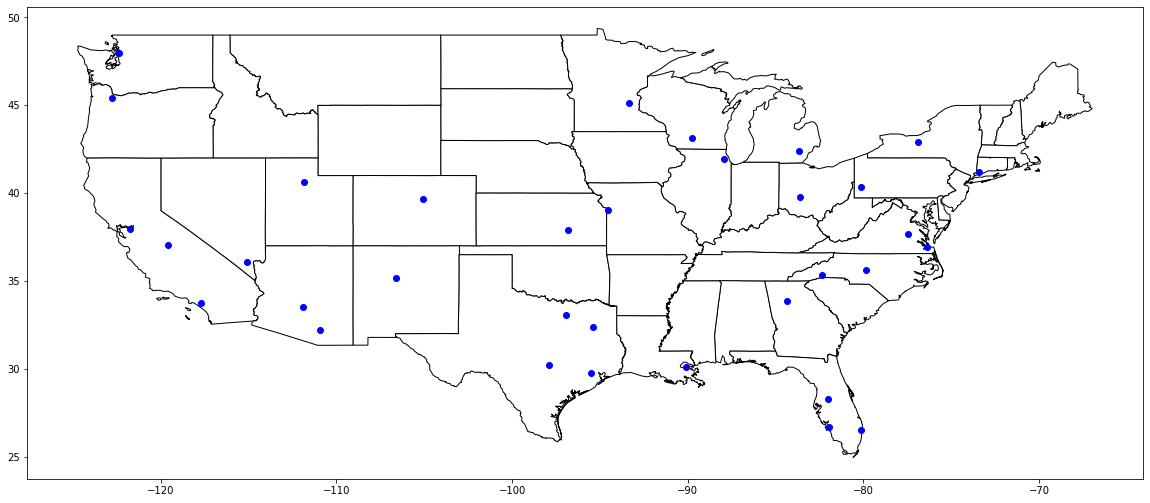

In [18]:
es_coords=get_coords(total_df[total_df['isES']==1])

cluster_es=cluster_and_plot(90,100,2,es_coords)

### Note the problem 
A
lthough California has reasonable number of clusters, New England is essentially one blob

### Tidy up the clustering result


In [19]:
es_labeled=pd.DataFrame(columns=['labels','lat','long'])
es_labeled['labels']=cluster_es[0].labels_
es_labeled['lat']=es_coords[:,0]
es_labeled['long']=es_coords[:,1]
es_labeled.head()

,labels,lat,long
0,0,45.569080,-122.946701
1,14,42.503670,-83.781059
2,4,34.004478,-117.684700
3,6,33.610741,-111.891472
4,30,29.985395,-95.346214


## Clustering Second Step:  Cluster the New England area seperately 

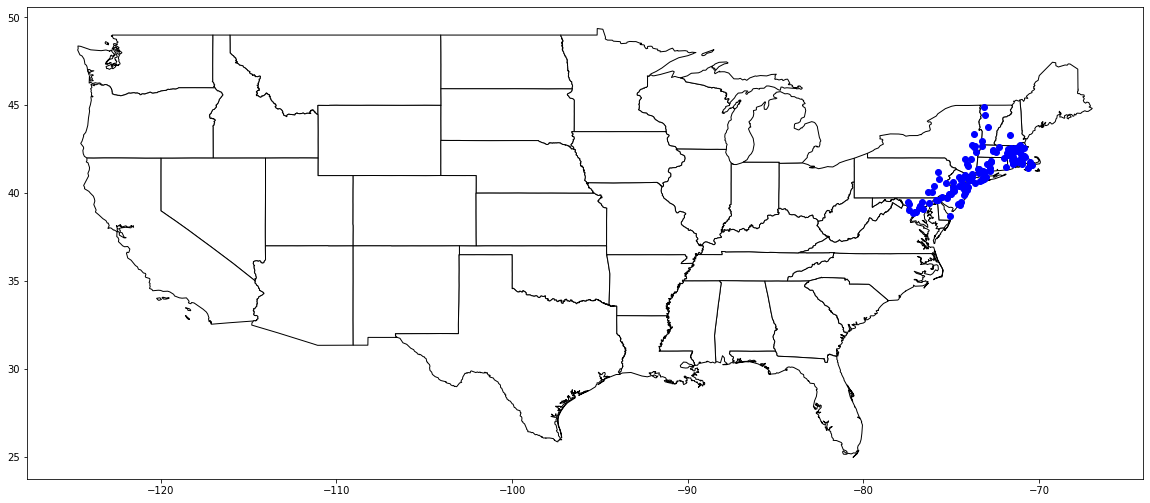

In [26]:
plot_coordinates_us(es_labeled[es_labeled['labels']==17].drop_duplicates())

In [27]:
es_coords_market17=get_coords(es_labeled[es_labeled['labels']==17][['lat','long']].drop_duplicates())



C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


ready to cluster with radius= 35max_ep: 60 and min_size: 6


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


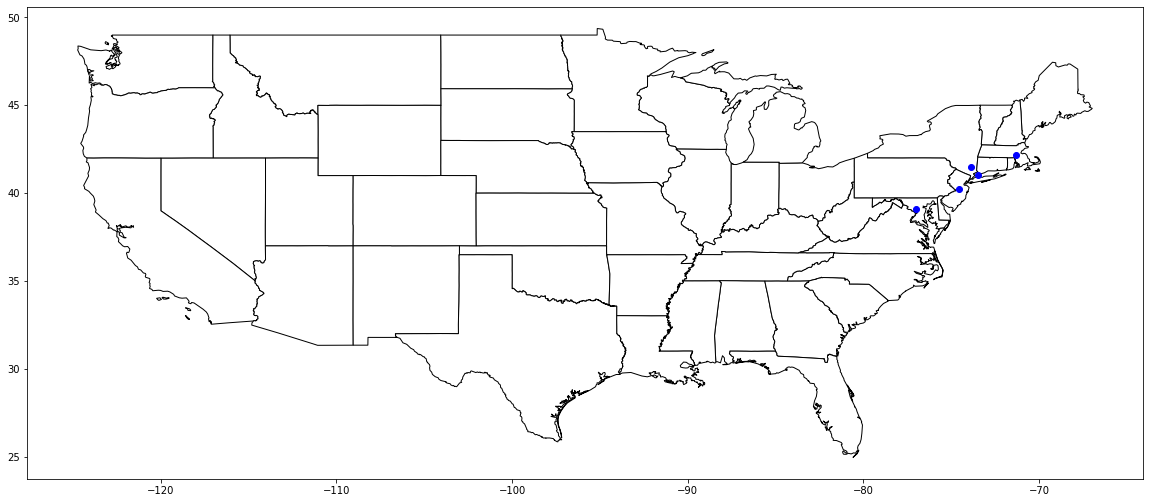

In [28]:
newengland_optics=cluster_and_plot(35,60,6,es_coords_market17)

## Label the New England restuls 

In [29]:
es_labeled_newengland=pd.DataFrame(columns=['labels','lat','long'])
es_labeled_newengland['labels']=newengland_optics[0].labels_
es_labeled_newengland['lat']=es_coords_market17[:,0]
es_labeled_newengland['long']=es_coords_market17[:,1]
es_labeled_newengland.head()

,labels,lat,long
0,-1,39.492413,-76.674446
1,2,40.889721,-73.941978
2,0,39.057537,-77.392006
3,-1,42.475479,-72.615402
4,-1,42.605438,-72.292076


### Examine the new cluster distances for just New England 

In [30]:
max_distance_list=[]
for label in set(es_labeled_newengland.labels):   
    a_cluster=es_labeled_newengland[es_labeled_newengland['labels']==label].drop_duplicates()
    length=len(a_cluster)
    x=[i for i in range(length)]
    x2_pairs=list(itertools.combinations(x, 2))
    distance_list=[]
    for pair in x2_pairs:
        distance=get_distance_from_index(a_cluster,pair)
        distance_list=distance_list+[distance]
    distance_list.sort()
    max_distance=distance_list[-1]
    median_distance=statistics.median(distance_list)
    num_per_cluster=length
    print('the market {} has max distance  {}, median distance {} with {} installers'.format(label,max_distance,median_distance,num_per_cluster))

the market 0 has max distance  44.34941109883043, median distance 25.03510717332689 with 11 installers
the market 1 has max distance  83.59776769475471, median distance 33.91003285320752 with 22 installers
the market 2 has max distance  111.41118773166728, median distance 39.715101311758055 with 31 installers
the market 3 has max distance  79.18166438702463, median distance 32.82154110936956 with 38 installers
the market -1 has max distance  442.5892049373908, median distance 170.4549715318919 with 42 installers


## merge es_labeled with 2nd step clustering es_labeled_newengland

### The market in es_labeled with label 17 need to be replaced. 

In [36]:
es_labeled.describe()

,labels,lat,long
count,463.000000,463.000000,463.000000
mean,12.747300,37.798171,-93.395793
std,9.218774,4.895085,19.449196
min,-1.000000,25.485147,-122.987328
25%,4.000000,34.068075,-117.088020
50%,17.000000,38.952515,-84.275970
75%,17.000000,41.626019,-74.911308
max,32.000000,48.796490,-69.747612


In [37]:
es_labeled_newengland.describe()

,labels,lat,long
count,144.000000,144.000000,144.000000
mean,1.083333,41.197720,-73.443966
std,1.588860,1.225786,1.855606
min,-1.000000,38.686005,-77.442986
25%,-1.000000,40.268212,-74.498030
50%,1.000000,41.249176,-73.395515
75%,3.000000,42.195731,-71.561939
max,3.000000,44.921329,-70.392014


### remap es_labeled_newengland labels


In [38]:
di_neweng_label = {0:33, 1:34 ,2:35 ,3:36,-1:17}
es_labeled_newengland_copy=es_labeled_newengland
es_labeled_newengland_copy=es_labeled_newengland_copy.replace({"labels": di_neweng_label})

In [40]:
es_labeled_new=pd.concat([es_labeled[es_labeled['labels']!=17],es_labeled_newengland_copy])

In [41]:
es_labeled_new.describe()

,labels,lat,long
count,463.000000,463.000000,463.000000
mean,16.699784,37.798171,-93.395793
std,13.202655,4.895085,19.449196
min,-1.000000,25.485147,-122.987328
25%,4.000000,34.068075,-117.088020
50%,17.000000,38.952515,-84.275970
75%,30.500000,41.626019,-74.911308
max,36.000000,48.796490,-69.747612


In [42]:
es_labeled_new.head(10)

,labels,lat,long
0,0,45.569080,-122.946701
1,14,42.503670,-83.781059
2,4,34.004478,-117.684700
3,6,33.610741,-111.891472
4,30,29.985395,-95.346214
5,18,37.759697,-77.481873
6,30,29.652205,-95.546227
7,6,33.323223,-111.623672
8,-1,46.842682,-96.728966
9,25,28.033060,-82.724373


In [43]:
es_labeled_new.tail(10)

,labels,lat,long
134,36,42.257755,-71.473526
135,36,42.261978,-71.801460
136,36,42.253487,-71.767929
137,36,42.268425,-71.613312
138,36,42.192245,-71.777649
139,36,42.519966,-71.763321
140,36,42.564663,-71.567299
141,17,42.671616,-73.246979
142,17,42.379925,-72.604042
143,17,42.364033,-72.458755


## Export: es_labeled90_100_2two_step.csv

In [ ]:
es_labeled_new.to_csv('es_labeled90_100_2two_step.csv')